GPU上での高速な物理シミュレーションは、(RLHFやOffline RLに押され気味とはいえ)強化学習界隈では話題のトピックですよね。また単純に、GPU上で爆速でシミュレーションが終わるのはなかなか楽しいものです。
[NVIDIA IsaacSym](https://docs.omniverse.nvidia.com/index.html)もありますが、jaxで強化学習パイプライン全体を高速化したいなら[brax](https://github.com/google/brax)が便利です。以前[紹介するブログ](https://kngwyu.github.io/rlog2/posts/jax-brax-haiku.html)も書きましたが、現在のバージョンではより精度のいい手法が選べるようになっていて、普通にMuJoCoの代わりに使えそうな感じです。しかし、最近単純な2次元物理シミュレーションでbraxが使えないかな？と思って検討してみたところ、無理ではないのだけれどどうにも使いづらいな...という印象でした。また、二次元物理シミュレーションをするのに、三次元のボールとかで当たり判定を行うのはちょっと計算資源がもったいない気もします。なら自分で作ってしまえばいいんじゃないか？ということでやってみました。

# Semi-implicit Eulerで物体を動かす

とりあえず、衝突のことはいったん忘れて、物体を動かしてみましょう。物体の位置・速度を$x, v$、その時間微分を$\dot{x} = \frac{dx}{dt}, \dot{v} = \frac{dv}{dt}$とおきます。ニュートンの運動の第二法則から、$F(t) = m \frac{d^2 x}{dt^2}(t)$ですから、最も単純な速度・位置更新の近似は、適当な十分短い時間間隔$\Delta t$をとって、

$$
\dot{x}_{t + 1} = \dot{v}_t \Delta t \\
\dot{v}_{t + 1} = \frac{F}{m} \Delta t
$$

と表せます（Explicit Euler)。これは不安定になるので、今回は安定しやすい[Semi-implicit Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method)を使います。これはアルゴリズム上はすごく単純で、

$$
\dot{v}_{t + 1} = \frac{F}{m} \Delta t \\
\dot{x}_{t + 1} = \dot{v}_{t + 1} \Delta t
$$

とすればいいです。


まず`Velocity`など、必要なものを適当に定義しておきます。剛体ですが、とりあえずこの世界には丸いものしかないことにして、`Circle`だけ定義しましょう。

In [132]:
from typing import Any, Sequence

import chex
import jax
import jax.numpy as jnp

Self = Any


class PyTreeOps:
    def __add__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x + y, self, o)
        else:
            return jax.tree_map(lambda x: x + o, self)

    def __sub__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x - y, self, o)
        else:
            return jax.tree_map(lambda x: x - o, self)

    def __mul__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x * o, self)

    def __neg__(self) -> Self:
        return jax.tree_map(lambda x: -x, self)

    def __truediv__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x / o, self)

    def reshape(self, shape: Sequence[int]) -> Self:
        return jax.tree_map(lambda x: x.reshape(shape), self)

    def tolist(self) -> list[Self]:
        leaves, treedef = jax.tree_util.tree_flatten(self)
        return [treedef.unflatten(leaf) for leaf in zip(*leaves)]

    def zeros_like(self) -> Any:
        return jax.tree_map(lambda x: jnp.zeros_like(x), self)


TWO_PI = jnp.pi * 2


@chex.dataclass
class Velocity(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Force(PyTreeOps):
    angle: jax.Array  # Angular (torque) force (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Position(PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Circle(PyTreeOps):
    mass: jax.Array
    moment: jax.Array
    radius: jax.Array
    elasticity: jax.Array
    friction: jax.Array
    rgba: jax.Array


@chex.dataclass
class State(PyTreeOps):
    p: Position
    v: Velocity
    f: Force


@chex.dataclass
class Space:
    dt: jax.Array | float
    damping: jax.Array | float
    gravity: jax.Array
    circle: Circle

    @property
    def mass(self) -> jax.Array:
        return self.circle.mass.reshape(-1, 1)
    
    @property
    def moment(self) -> jax.Array:
        return self.circle.moment

次は描画用の関数を準備しましょう。

In [133]:
from typing import Iterable

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Circle as CirclePatch


def visualize_balls(ax: Axes, circles: Circle, positions: Iterable[Position]) -> None:
    pos = list(positions)
    circle_list = circles.tolist()
    for pi in pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)

Semi-implicit Eulerを実装します。

In [134]:
def update_velocity(space: Space, state: State) -> State:
    damped = state.v * space.damping
    v_xy = damped.xy + (space.gravity + state.f.xy / space.mass) * space.dt
    v_ang = damped.angle + state.f.angle / space.moment * space.dt
    return state.replace(v=Velocity(angle=v_ang, xy=v_xy), f=state.f.zeros_like())

def update_position(space: Space, state: State) -> State:
    v_dt = state.v * space.dt
    xy = state.p.xy + v_dt.xy
    angle = (state.p.angle + v_dt.angle + TWO_PI) % TWO_PI
    return state.replace(p=Position(angle=angle, xy=xy))

とりあえずボールを落としてみましょう。

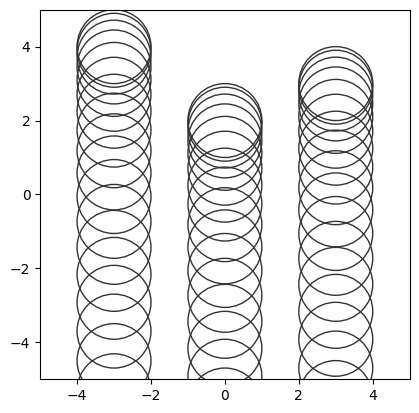

In [135]:
circles = Circle(
    mass=jnp.ones(3),
    radius=jnp.ones(3),
    moment=jnp.ones(3) * 0.5,
    elasticity=jnp.ones(3),
    friction=jnp.ones(3),
    rgba=jnp.tile(jnp.array([0.2, 0.2, 0.2, 1.0]), (3, 1)),
)
space = Space(dt=0.1, damping=0.9, gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.array([-2, 0.1, 0.2]),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3]]),
)
v = Velocity(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
f = Force(angle=jnp.zeros(3), xy=jnp.zeros((3, 2)))
state = State(p=p, v=v, f=f)
positions = [state.p]
for i in range(20):
    state = update_velocity(space, state)
    state = update_position(space, state)
    positions.append(state.p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)

できたっぽいですね。

## 衝突判定を行う

次に衝突判定を実装してみましょう。円と円しかないので判定自体は簡単ですが、後で衝突後の物理状態を求めるために計算するときのため、衝突した場所やそれによって発生したインパルスといった情報を保存しておく必要があります。

In [188]:
from itertools import chain
from typing import Any, Callable

from jax import tree_util as jtu

Axis = Sequence[int] | int


def safe_norm(x: jax.Array, axis: Axis | None = None) -> jax.Array:
    is_zero = jnp.allclose(x, 0.0)
    x = jnp.where(is_zero, jnp.ones_like(x), x)
    n = jnp.linalg.norm(x, axis=axis)
    return jnp.where(is_zero, 0.0, n)  # pyright: ignore


def normalize(x: jax.Array, axis: Axis | None = None) -> tuple[jax.Array, jax.Array]:
    norm = safe_norm(x, axis=axis)
    n = x / (norm + 1e-6 * (norm == 0.0))
    return n, norm


def tree_map2(
    f: Callable[..., Any],
    tree: Any,
    *rest: Any,
    is_leaf: Callable[[Any], bool] | None = None
) -> tuple[Any, Any]:
    """Same as tree_map, but returns a tuple"""
    leaves, treedef = jtu.tree_flatten(tree, is_leaf)
    all_leaves = [leaves] + [treedef.flatten_up_to(r) for r in rest]
    result = [f(*xs) for xs in zip(*all_leaves)]
    a = treedef.unflatten([elem[0] for elem in result])
    b = treedef.unflatten([elem[1] for elem in result])
    return a, b


def generate_all_pairs(x: jax.Array) -> tuple[jax.Array, jax.Array]:
    """Returns two arrays that iterate over all combination of elements in x."""
    # x.shape[0] > 0
    chex.assert_axis_dimension_gt(x, 0, 1)
    n = x.shape[0]
    # (a, a, a, b, b, c)
    n_repeats = ()
    outer_loop = jnp.repeat(
        x,
        jnp.arange(n, 0, -1),
        axis=0,
        total_repeat_length=n * (n - 1),
    )
    # (a, b, c, a, b, c)
    n_repeats = (n - 1,) + (1,) * (x.ndim - 1)
    inner_loop = jnp.tile(x, n_repeats)
    return outer_loop, inner_loop


@chex.dataclass
class Contact:
    pos: jax.Array
    normal: jax.Array
    penetration: jax.Array
    elasticity: jax.Array
    friction: jax.Array


def circle_to_circle(a: Circle, b: Circle, a_pos: Position, b_pos: Position) -> Contact:
    b2a_normal, dist = normalize(a_pos.xy - b_pos.xy)
    penetration = a.radius + b.radius - dist
    a_contact = a_pos.xy - b2a_normal * a.radius
    b_contact = b_pos.xy + b2a_normal * b.radius
    pos = (a_contact + b_contact) * 0.5
    return Contact(
        pos=pos,
        normal=b2a_normal,
        penetration=penetration,
        elasticity=(a.elasticity + b.elasticity) * 0.5,
        friction=(a.friction + b.friction) * 0.5,
    )


def check_contacts(space: Space, position: Position) -> Contact:
    circle1, circle2 = tree_map2(generate_all_pairs, space.circle)
    pos1, pos2 = tree_map2(generate_all_pairs, position)
    return jax.vmap(circle_to_circle)(circle1, circle2, pos1, pos2)

[ True False False False False False  True False False False False False
 False  True  True False False False False  True]
[ True False False  True False False  True False False False False False
 False  True  True False False False False  True]
[ True False False  True False False  True False False False False False
 False  True  True False  True False False  True]
[ True False False  True False False  True False False  True False False
 False  True  True False  True  True False  True]
[ True False False  True False False  True False False  True False False
 False  True  True False  True  True False  True]
[ True False False  True False False  True False False  True False False
 False  True  True False  True  True False  True]
[ True False False  True False False  True False False  True False False
 False  True  True False  True  True False  True]
[ True False False False False False  True False False  True False False
 False  True  True False  True  True False  True]
[ True False Fal

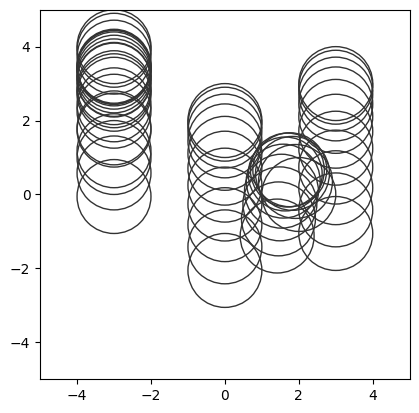

In [189]:
N = 5
circles = Circle(
    mass=jnp.ones(N),
    radius=jnp.ones(N),
    moment=jnp.ones(N) * 0.5,
    elasticity=jnp.ones(N),
    friction=jnp.ones(N),
    rgba=jnp.tile(jnp.array([0.2, 0.2, 0.2, 1.0]), (N, 1)),
)
space = Space(dt=0.1, damping=0.9, gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.zeros(N),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3], [-3, 1], [2, 0]]),
)
v_xy = jnp.concatenate((jnp.zeros((N - 2, 2)), jnp.array([[0, 10.0], [-1.0, 5.0]])))
v = Velocity(angle=jnp.zeros(N), xy=v_xy)
f = Force(angle=jnp.zeros(N), xy=jnp.zeros((N, 2)))
state = State(p=p, v=v, f=f)
positions = [state.p]
for i in range(10):
    state = update_velocity(space, state)
    state = update_position(space, state)
    positions.append(state.p)
    contacts = check_contacts(space, state.p)
    print(contacts.penetration > 0)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)